<a href="https://colab.research.google.com/github/rebelahsan/Mo-Ahsan-Ahmad/blob/main/BM_MNIST_main_code_and_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 1/1, Avg MSE: 0.07


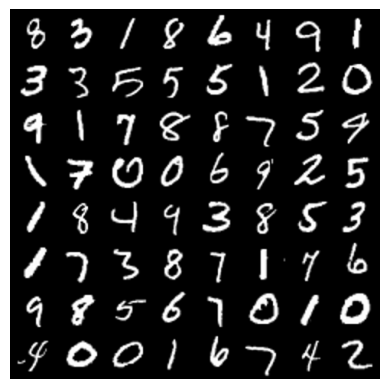

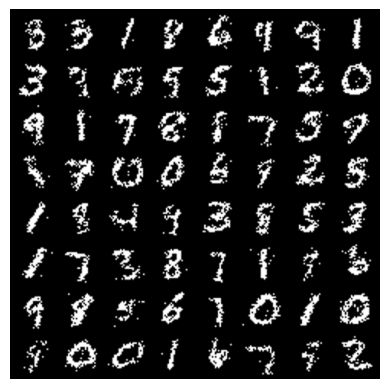

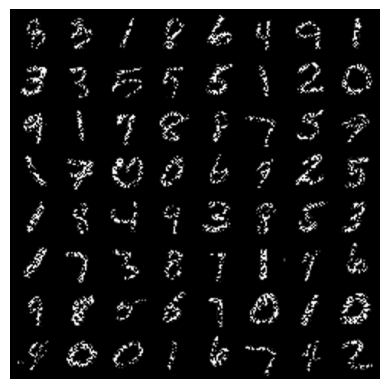

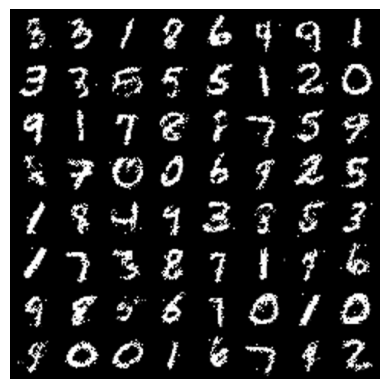

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import random
from PIL import Image

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset
batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Save a specific batch of images
def save_initial_batch(loader, file_path='initial_batch.pth'):
    images, _ = next(iter(loader))
    torch.save(images, file_path)

# Load the saved batch
def load_initial_batch(file_path='initial_batch.pth'):
    return torch.load(file_path)

# Define the Boltzmann Machine model
class BM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(BM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.1)
        self.Wvv = nn.Parameter(torch.randn(n_visible, n_visible) * 0.1)
        self.Whh = nn.Parameter(torch.randn(n_hidden, n_hidden) * 0.1)
        self.b_visible = nn.Parameter(torch.zeros(n_visible))
        self.b_hidden = nn.Parameter(torch.zeros(n_hidden))

    def sample_hidden(self, visible, temperature=1.0):
        activation = torch.matmul(visible, self.W) + self.b_hidden
        p_hidden = torch.sigmoid(activation / temperature)
        sampled_hidden = torch.bernoulli(p_hidden)
        return sampled_hidden

    def sample_visible(self, hidden, temperature=1.0):
        activation = torch.matmul(hidden, self.W.t()) + self.b_visible
        p_visible = torch.sigmoid(activation / temperature)
        sampled_visible = torch.bernoulli(p_visible)
        return sampled_visible

    def energy(self, visible, hidden):
        batch_size = visible.shape[0]
        energy = -torch.sum(torch.matmul(visible, self.W) * hidden, dim=1)
        energy -= 0.5 * torch.sum(torch.matmul(visible, self.Wvv) * visible, dim=1)
        energy -= 0.5 * torch.sum(torch.matmul(hidden, self.Whh) * hidden, dim=1)
        energy -= torch.sum(visible * self.b_visible, dim=1)
        energy -= torch.sum(hidden * self.b_hidden, dim=1)
        return energy.mean()

    def forward(self, visible, temperature=1.0):
        hidden = self.sample_hidden(visible, temperature)
        visible_gibbs = self.sample_visible(hidden, temperature)
        return visible, visible_gibbs

def calculate_mse(original, reconstructed):
    return ((original - reconstructed) ** 2).mean()

def train(bm, train_loader, optimizer, scheduler, epochs, device):
    bm.to(device)
    for epoch in range(epochs):
        total_mse = 0
        for batch, (data, _) in enumerate(train_loader):
            data = data.view(-1, 784).to(device)
            hidden = bm.sample_hidden(data)
            visible_recon = bm.sample_visible(hidden)
            mse = calculate_mse(data, visible_recon)
            total_mse += mse.item()

            hidden_recon = bm.sample_hidden(visible_recon)
            positive_grad = bm.energy(data, hidden)
            negative_grad = bm.energy(visible_recon, hidden_recon)
            loss = positive_grad - negative_grad

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        average_mse = total_mse / len(train_loader)
        print(f"Epoch: {epoch+1}/{epochs}, Avg MSE: {average_mse:.2f}")

def show_and_save(img, file_name, scale_factor=2):
    pic = np.transpose(img.cpu().numpy(), (1, 2, 0))
    pil_img = Image.fromarray((pic * 255).astype(np.uint8))

    # Resize the image
    new_size = (pil_img.width * scale_factor, pil_img.height * scale_factor)
    resized_img = pil_img.resize(new_size, Image.BICUBIC)

    # Use matplotlib to show the image
    plt.imshow(resized_img)
    plt.axis('off')
    plt.show()

    resized_img.save(file_name)

def mask_image(img, mask_fraction=0.5):
    mask = torch.rand_like(img) > mask_fraction
    masked_img = img * mask.float()
    return masked_img, mask

def reconstruct_image_gibbs(model, masked_img, mask, device, num_iterations=1000, temperature=1.0):
    model.eval()
    visible = masked_img.clone().to(device)
    mask = mask.to(device)

    for _ in range(num_iterations):
        hidden = model.sample_hidden(visible, temperature)
        visible_new = model.sample_visible(hidden, temperature)
        visible = mask.float() * masked_img + (~mask).float() * visible_new

    # Clamp values to avoid extreme values
    visible = torch.clamp(visible, 0.0, 1.0)

    return visible

# HYPER-PARAMETERS
num_epochs = 1  # Set the number of epochs to 20
learning_rate = 0.001  # Adjust the learning rate for finer updates
num_hidden = 1000  # Keep the increased number of hidden units
num_visible = 784

# Initialize model, optimizer, and scheduler
model = BM(num_visible, num_hidden)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Save the initial batch of images
save_initial_batch(train_loader)
# Train the Boltzmann Machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model, train_loader, optimizer, scheduler, num_epochs, device=device)



# Load the initial batch of images
images = load_initial_batch()

# Generate and show images for the saved batch of images
model.to(device)
images = images.float()
images = images.view(-1, 784)
images = images.to(device)
v, v_gibbs = model.forward(images)

# Show original images
show_and_save(make_grid(images.view(batch_size, 1, 28, 28).data), 'original_imagesMNIST1.png')

# Show generated images
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'generated_imagesMNIST1.png')

# Mask a batch of images
masked_images, mask = mask_image(images, mask_fraction=0.5)

# Move to device
masked_images = masked_images.to(device)
mask = mask.to(device)

# Reconstruct images with Gibbs sampling
reconstructed_images = reconstruct_image_gibbs(model, masked_images, mask, device, num_iterations=1000, temperature=0.9)

# Show masked and reconstructed images
show_and_save(make_grid(masked_images.view(batch_size, 1, 28, 28).data), 'masked_imagesMNIST1.png')
show_and_save(make_grid(reconstructed_images.view(batch_size, 1, 28, 28).data), 'reconstructed_imagesMNIST1.png')


Epoch: 1/5, Avg MSE: 0.07
Epoch: 2/5, Avg MSE: 0.05
Epoch: 3/5, Avg MSE: 0.05
Epoch: 4/5, Avg MSE: 0.04
Epoch: 5/5, Avg MSE: 0.04


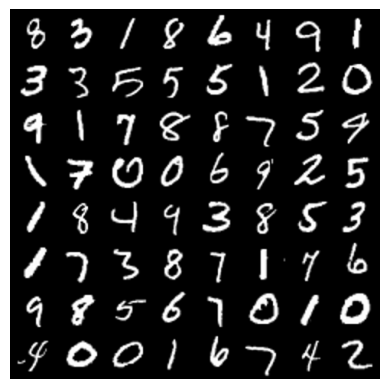

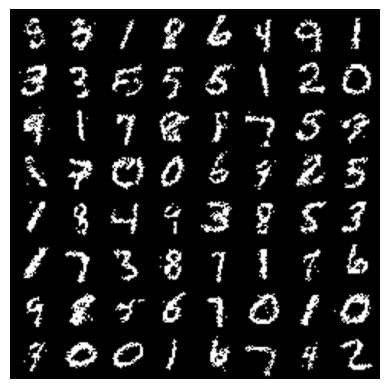

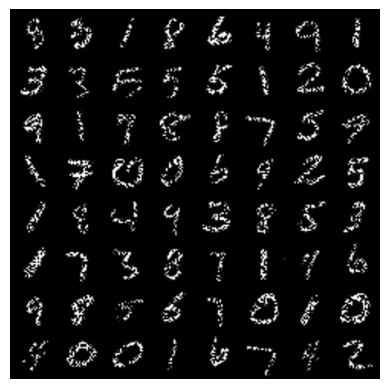

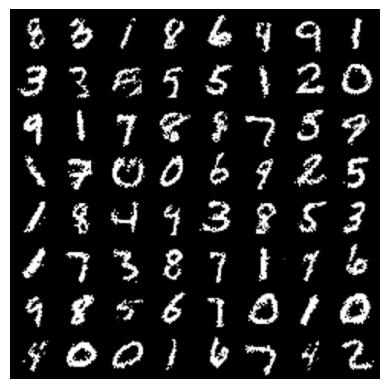

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import random
from PIL import Image

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset
batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Save a specific batch of images
def save_initial_batch(loader, file_path='initial_batch.pth'):
    images, _ = next(iter(loader))
    torch.save(images, file_path)

# Load the saved batch
def load_initial_batch(file_path='initial_batch.pth'):
    return torch.load(file_path)

# Define the Boltzmann Machine model
class BM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(BM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.1)
        self.Wvv = nn.Parameter(torch.randn(n_visible, n_visible) * 0.1)
        self.Whh = nn.Parameter(torch.randn(n_hidden, n_hidden) * 0.1)
        self.b_visible = nn.Parameter(torch.zeros(n_visible))
        self.b_hidden = nn.Parameter(torch.zeros(n_hidden))

    def sample_hidden(self, visible, temperature=1.0):
        activation = torch.matmul(visible, self.W) + self.b_hidden
        p_hidden = torch.sigmoid(activation / temperature)
        sampled_hidden = torch.bernoulli(p_hidden)
        return sampled_hidden

    def sample_visible(self, hidden, temperature=1.0):
        activation = torch.matmul(hidden, self.W.t()) + self.b_visible
        p_visible = torch.sigmoid(activation / temperature)
        sampled_visible = torch.bernoulli(p_visible)
        return sampled_visible

    def energy(self, visible, hidden):
        batch_size = visible.shape[0]
        energy = -torch.sum(torch.matmul(visible, self.W) * hidden, dim=1)
        energy -= 0.5 * torch.sum(torch.matmul(visible, self.Wvv) * visible, dim=1)
        energy -= 0.5 * torch.sum(torch.matmul(hidden, self.Whh) * hidden, dim=1)
        energy -= torch.sum(visible * self.b_visible, dim=1)
        energy -= torch.sum(hidden * self.b_hidden, dim=1)
        return energy.mean()

    def forward(self, visible, temperature=1.0):
        hidden = self.sample_hidden(visible, temperature)
        visible_gibbs = self.sample_visible(hidden, temperature)
        return visible, visible_gibbs

def calculate_mse(original, reconstructed):
    return ((original - reconstructed) ** 2).mean()

def train(bm, train_loader, optimizer, scheduler, epochs, device):
    bm.to(device)
    for epoch in range(epochs):
        total_mse = 0
        for batch, (data, _) in enumerate(train_loader):
            data = data.view(-1, 784).to(device)
            hidden = bm.sample_hidden(data)
            visible_recon = bm.sample_visible(hidden)
            mse = calculate_mse(data, visible_recon)
            total_mse += mse.item()

            hidden_recon = bm.sample_hidden(visible_recon)
            positive_grad = bm.energy(data, hidden)
            negative_grad = bm.energy(visible_recon, hidden_recon)
            loss = positive_grad - negative_grad

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        average_mse = total_mse / len(train_loader)
        print(f"Epoch: {epoch+1}/{epochs}, Avg MSE: {average_mse:.2f}")

def show_and_save(img, file_name, scale_factor=2):
    pic = np.transpose(img.cpu().numpy(), (1, 2, 0))
    pil_img = Image.fromarray((pic * 255).astype(np.uint8))

    # Resize the image
    new_size = (pil_img.width * scale_factor, pil_img.height * scale_factor)
    resized_img = pil_img.resize(new_size, Image.BICUBIC)

    # Use matplotlib to show the image
    plt.imshow(resized_img)
    plt.axis('off')
    plt.show()

    resized_img.save(file_name)

def mask_image(img, mask_fraction=0.5):
    mask = torch.rand_like(img) > mask_fraction
    masked_img = img * mask.float()
    return masked_img, mask

def reconstruct_image_gibbs(model, masked_img, mask, device, num_iterations=1000, temperature=1.0):
    model.eval()
    visible = masked_img.clone().to(device)
    mask = mask.to(device)

    for _ in range(num_iterations):
        hidden = model.sample_hidden(visible, temperature)
        visible_new = model.sample_visible(hidden, temperature)
        visible = mask.float() * masked_img + (~mask).float() * visible_new

    # Clamp values to avoid extreme values
    visible = torch.clamp(visible, 0.0, 1.0)

    return visible

# HYPER-PARAMETERS
num_epochs = 5  # Set the number of epochs to 20
learning_rate = 0.001  # Adjust the learning rate for finer updates
num_hidden = 1000  # Keep the increased number of hidden units
num_visible = 784

# Initialize model, optimizer, and scheduler
model = BM(num_visible, num_hidden)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Save the initial batch of images
save_initial_batch(train_loader)
# Train the Boltzmann Machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model, train_loader, optimizer, scheduler, num_epochs, device=device)



# Load the initial batch of images
images = load_initial_batch()

# Generate and show images for the saved batch of images
model.to(device)
images = images.float()
images = images.view(-1, 784)
images = images.to(device)
v, v_gibbs = model.forward(images)

# Show original images
show_and_save(make_grid(images.view(batch_size, 1, 28, 28).data), 'original_imagesMNIST5.png')

# Show generated images
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'generated_imagesMNIST5.png')

# Mask a batch of images
masked_images, mask = mask_image(images, mask_fraction=0.5)

# Move to device
masked_images = masked_images.to(device)
mask = mask.to(device)

# Reconstruct images with Gibbs sampling
reconstructed_images = reconstruct_image_gibbs(model, masked_images, mask, device, num_iterations=1000, temperature=0.9)

# Show masked and reconstructed images
show_and_save(make_grid(masked_images.view(batch_size, 1, 28, 28).data), 'masked_imagesMNIST5.png')
show_and_save(make_grid(reconstructed_images.view(batch_size, 1, 28, 28).data), 'reconstructed_imagesMNIST5.png')


# with 10 epochs

Epoch: 1/10, Avg MSE: 0.07
Epoch: 2/10, Avg MSE: 0.05
Epoch: 3/10, Avg MSE: 0.05
Epoch: 4/10, Avg MSE: 0.04
Epoch: 5/10, Avg MSE: 0.04
Epoch: 6/10, Avg MSE: 0.04
Epoch: 7/10, Avg MSE: 0.04
Epoch: 8/10, Avg MSE: 0.04
Epoch: 9/10, Avg MSE: 0.04
Epoch: 10/10, Avg MSE: 0.04


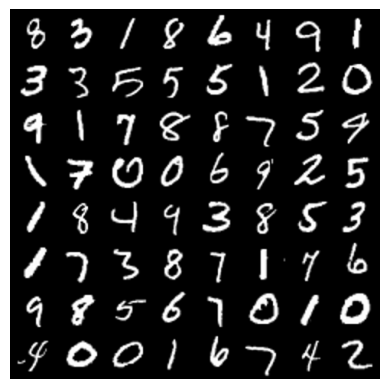

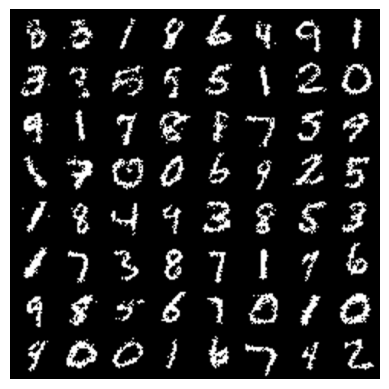

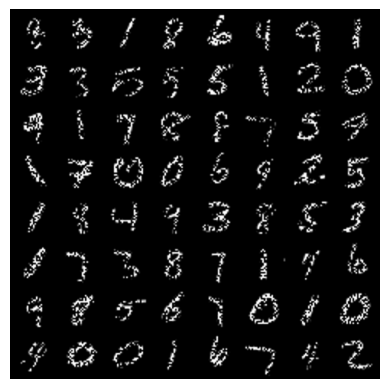

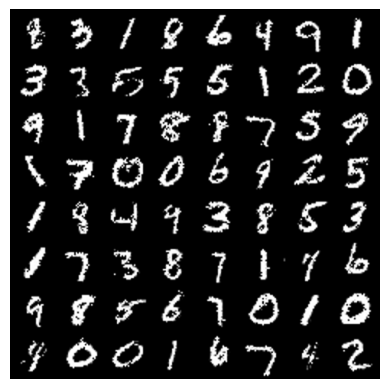

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import random
from PIL import Image

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset
batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Save a specific batch of images
def save_initial_batch(loader, file_path='initial_batch.pth'):
    images, _ = next(iter(loader))
    torch.save(images, file_path)

# Load the saved batch
def load_initial_batch(file_path='initial_batch.pth'):
    return torch.load(file_path)

# Define the Boltzmann Machine model
class BM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(BM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.1)
        self.Wvv = nn.Parameter(torch.randn(n_visible, n_visible) * 0.1)
        self.Whh = nn.Parameter(torch.randn(n_hidden, n_hidden) * 0.1)
        self.b_visible = nn.Parameter(torch.zeros(n_visible))
        self.b_hidden = nn.Parameter(torch.zeros(n_hidden))

    def sample_hidden(self, visible, temperature=1.0):
        activation = torch.matmul(visible, self.W) + self.b_hidden
        p_hidden = torch.sigmoid(activation / temperature)
        sampled_hidden = torch.bernoulli(p_hidden)
        return sampled_hidden

    def sample_visible(self, hidden, temperature=1.0):
        activation = torch.matmul(hidden, self.W.t()) + self.b_visible
        p_visible = torch.sigmoid(activation / temperature)
        sampled_visible = torch.bernoulli(p_visible)
        return sampled_visible

    def energy(self, visible, hidden):
        batch_size = visible.shape[0]
        energy = -torch.sum(torch.matmul(visible, self.W) * hidden, dim=1)
        energy -= 0.5 * torch.sum(torch.matmul(visible, self.Wvv) * visible, dim=1)
        energy -= 0.5 * torch.sum(torch.matmul(hidden, self.Whh) * hidden, dim=1)
        energy -= torch.sum(visible * self.b_visible, dim=1)
        energy -= torch.sum(hidden * self.b_hidden, dim=1)
        return energy.mean()

    def forward(self, visible, temperature=1.0):
        hidden = self.sample_hidden(visible, temperature)
        visible_gibbs = self.sample_visible(hidden, temperature)
        return visible, visible_gibbs

def calculate_mse(original, reconstructed):
    return ((original - reconstructed) ** 2).mean()

def train(bm, train_loader, optimizer, scheduler, epochs, device):
    bm.to(device)
    for epoch in range(epochs):
        total_mse = 0
        for batch, (data, _) in enumerate(train_loader):
            data = data.view(-1, 784).to(device)
            hidden = bm.sample_hidden(data)
            visible_recon = bm.sample_visible(hidden)
            mse = calculate_mse(data, visible_recon)
            total_mse += mse.item()

            hidden_recon = bm.sample_hidden(visible_recon)
            positive_grad = bm.energy(data, hidden)
            negative_grad = bm.energy(visible_recon, hidden_recon)
            loss = positive_grad - negative_grad

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        average_mse = total_mse / len(train_loader)
        print(f"Epoch: {epoch+1}/{epochs}, Avg MSE: {average_mse:.2f}")

def show_and_save(img, file_name, scale_factor=2):
    pic = np.transpose(img.cpu().numpy(), (1, 2, 0))
    pil_img = Image.fromarray((pic * 255).astype(np.uint8))

    # Resize the image
    new_size = (pil_img.width * scale_factor, pil_img.height * scale_factor)
    resized_img = pil_img.resize(new_size, Image.BICUBIC)

    # Use matplotlib to show the image
    plt.imshow(resized_img)
    plt.axis('off')
    plt.show()

    resized_img.save(file_name)

def mask_image(img, mask_fraction=0.5):
    mask = torch.rand_like(img) > mask_fraction
    masked_img = img * mask.float()
    return masked_img, mask

def reconstruct_image_gibbs(model, masked_img, mask, device, num_iterations=1000, temperature=1.0):
    model.eval()
    visible = masked_img.clone().to(device)
    mask = mask.to(device)

    for _ in range(num_iterations):
        hidden = model.sample_hidden(visible, temperature)
        visible_new = model.sample_visible(hidden, temperature)
        visible = mask.float() * masked_img + (~mask).float() * visible_new

    # Clamp values to avoid extreme values
    visible = torch.clamp(visible, 0.0, 1.0)

    return visible

# HYPER-PARAMETERS
num_epochs = 10  # Set the number of epochs to 20
learning_rate = 0.001  # Adjust the learning rate for finer updates
num_hidden = 1000  # Keep the increased number of hidden units
num_visible = 784

# Initialize model, optimizer, and scheduler
model = BM(num_visible, num_hidden)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Save the initial batch of images
save_initial_batch(train_loader)
# Train the Boltzmann Machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model, train_loader, optimizer, scheduler, num_epochs, device=device)



# Load the initial batch of images
images = load_initial_batch()

# Generate and show images for the saved batch of images
model.to(device)
images = images.float()
images = images.view(-1, 784)
images = images.to(device)
v, v_gibbs = model.forward(images)

# Show original images
show_and_save(make_grid(images.view(batch_size, 1, 28, 28).data), 'original_imagesMNIST10.png')

# Show generated images
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'generated_imagesMNIST10.png')

# Mask a batch of images
masked_images, mask = mask_image(images, mask_fraction=0.5)

# Move to device
masked_images = masked_images.to(device)
mask = mask.to(device)

# Reconstruct images with Gibbs sampling
reconstructed_images = reconstruct_image_gibbs(model, masked_images, mask, device, num_iterations=1000, temperature=0.9)

# Show masked and reconstructed images
show_and_save(make_grid(masked_images.view(batch_size, 1, 28, 28).data), 'masked_imagesMNIST10.png')
show_and_save(make_grid(reconstructed_images.view(batch_size, 1, 28, 28).data), 'reconstructed_imagesMNIST10.png')
